In [1]:
!date

Thu May 22 12:00:14 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants
import pickle
from tqdm import tqdm

In [4]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [5]:
def get_regs(events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 2.0 
    #n_scans = epi.shape[-1]
    n_scans = 156
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    face_reg = X1[['face']].values.sum(axis=1)
    place_reg = X1[['house','scene']].values.sum(axis=1)
    #place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)
    
    return face_reg,place_reg

events_fn_temp = '../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
face_reg,place_reg = get_regs(events_fn_temp.format(sub='sub-01',r=1))

In [6]:
def get_contrast_val(s,r,Y,return_type='contrast',contype='face'):
    from nilearn.glm.first_level import make_first_level_design_matrix
    
    events = pd.read_csv(events_fn_temp.format(sub=subs[s],r=r),delimiter='\t')

    t_r = 2.0 
    n_scans = 156  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    #['body', 'face', 'house', 'object', 'scene', 'scramble', 'drift_1','drift_2', 'drift_3', 'constant']
    
    if contype=='face':
        contrast_vector = np.array([-1,5,-1,-1,-1,-1,0,0,0,0]) # Faces > Rest
        contrast_values = beta @ contrast_vector
    elif contype=='place':
        contrast_vector = np.array([-1,-1,3,-1,3,-1,0,0,0,0]) # Places over Rest
        contrast_values = beta @ contrast_vector
    
    if return_type=='contrast':
        return contrast_values.mean()
    elif return_type=='betas':
        return beta.mean(axis=0)

In [7]:
ffa_mask_temp = '../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'
ppa_mask_temp = '../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'

In [8]:
subs = ['sub-01','sub-02','sub-03','sub-04','sub-05','sub-09','sub-10','sub-14','sub-15','sub-16','sub-17','sub-18','sub-19','sub-20',]

In [9]:
faceMap = ants.image_read('../Misc/ffa_map_resampled_forrest.nii.gz')
faceMap_mask = faceMap.numpy()>5
faceMap_mask.sum()

953

In [10]:
roi = ants.image_read('../Data/StudyForrest/fmriprep/mask_roi.nii')
roni = ants.image_read('../Data/StudyForrest/fmriprep/mask_roni.nii')

In [11]:
def get_result(fn_temp,subFormat='name'):
    result = np.zeros((14,4,6))
    for s in tqdm(range(14)):
        for r in [1,2,3,4]:
            
            if subFormat=='number':
                subim = ants.image_read(os.path.join(fn_temp.format(s=s,r=r)))
            elif subFormat=='name':
                subim = ants.image_read(os.path.join(fn_temp.format(sub=subs[s],r=r)))
            
            subFFA = ants.image_read(os.path.join(ffa_mask_temp.format(sub=subs[s])))
            valsFFA = subim.numpy()[subFFA.numpy()==1]
            valsFFA = valsFFA[valsFFA.std(axis=1)>1e-3,:]
            
            subPPA = ants.image_read(os.path.join(ppa_mask_temp.format(sub=subs[s])))
            valsPPA = subim.numpy()[subPPA.numpy()==1]
            valsPPA = valsPPA[valsPPA.std(axis=1)>1e-3,:]

            corr2reg_face = np.nanmean(correlate_columns(valsFFA.transpose(),np.array([face_reg for _ in range(valsFFA.shape[0])]).transpose()))
            contrastVal_face = get_contrast_val(s,r,valsFFA,return_type='contrast',contype='face')
            
            corr2reg_place = np.nanmean(correlate_columns(valsPPA.transpose(),np.array([place_reg for _ in range(valsPPA.shape[0])]).transpose()))
            contrastVal_place = get_contrast_val(s,r,valsPPA,return_type='contrast',contype='place')
            
            arr1=subim.numpy()[(roi.numpy()==1) * (subFFA.numpy()==True)]
            arr2=subim.numpy()[(roi.numpy()==1) * (subFFA.numpy()==False)]
            arr1=arr1[arr1.std(axis=1)>1e-3]
            arr2=arr2[arr2.std(axis=1)>1e-3]
            r1=correlate_columns(arr1.transpose(),np.array([face_reg for _ in range(arr1.shape[0])]).transpose())
            r2=correlate_columns(arr2.transpose(),np.array([face_reg for _ in range(arr2.shape[0])]).transpose())
            specificity_face = r1.mean()-r2.mean()
            
            arr1=subim.numpy()[(roi.numpy()==1) * (subPPA.numpy()==True)]
            arr2=subim.numpy()[(roi.numpy()==1) * (subPPA.numpy()==False)]
            arr1=arr1[arr1.std(axis=1)>1e-3]
            arr2=arr2[arr2.std(axis=1)>1e-3]
            r1=correlate_columns(arr1.transpose(),np.array([place_reg for _ in range(arr1.shape[0])]).transpose())
            r2=correlate_columns(arr2.transpose(),np.array([place_reg for _ in range(arr2.shape[0])]).transpose())
            specificity_place = r1.mean()-r2.mean()

            result[s,r-1,0] = corr2reg_face
            result[s,r-1,1] = contrastVal_face
            result[s,r-1,2] = corr2reg_place
            result[s,r-1,3] = contrastVal_place
            result[s,r-1,4] = specificity_face
            result[s,r-1,5] = specificity_place
            
    return result

In [12]:
fn_temp = '../Data/StudyForrest/ensembles_last_CVAE/fixed-seed-00-YuOrig-00-DataloaderFix/signal_S{s}_R{r}_avg.nii.gz'
result_CVAE_Yu = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:54<00:00,  3.89s/it]


In [13]:
fn_temp = '../Data/StudyForrest/fmriprep/{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
result_preproc = get_result(fn_temp,subFormat='name')

100%|██████████| 14/14 [00:56<00:00,  4.05s/it]


In [14]:
fn_temp = '../Data/StudyForrest/fmriprep/{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_COMPCOR-RONI.nii'
result_compcor = get_result(fn_temp,subFormat='name')

100%|██████████| 14/14 [00:49<00:00,  3.54s/it]


In [15]:
fn_temp = '../Data/StudyForrest/ensembles_last_CVAE/DeepCor-Forrest-face-v5/signal_S{s}_R{r}_avg.nii.gz'
result_CVAE_AA = get_result(fn_temp,subFormat='number')

 14%|█▍        | 2/14 [00:08<00:49,  4.12s/it]/home/aglinska/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/aglinska/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
<ipython-input-4-9f9a06f806b9>:24: RuntimeWarning: overflow encountered in square
  denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
/home/aglinska/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 14/14 [00:56<00:00,  4.00s/it]


In [16]:
model_names=['conv_denoise',
 'conv_denoise500',
 'conv_denoise_bn',
 'conv_denoise_large',
 'conv_denoise_large500',
 'conv_smooth',
 'conv_smooth-small',
 'conv_weights_unet_denoise',
 'conv_weights_unet_denoise500']

In [17]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_denoise-avg.nii.gz'
result_conv_denoise = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:54<00:00,  3.89s/it]


In [18]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_denoise500-avg.nii.gz'
result_conv_denoise500 = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:53<00:00,  3.82s/it]


In [19]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_denoise_bn-avg.nii.gz'
result_conv_denoise_bn = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:54<00:00,  3.86s/it]


In [20]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_smooth-avg.nii.gz'
result_conv_smooth = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:53<00:00,  3.85s/it]


In [21]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_denoise_large-avg.nii.gz'
result_conv_denoise_large = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:54<00:00,  3.92s/it]


In [22]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_denoise_large500-avg.nii.gz'
result_conv_denoise_large500 = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:53<00:00,  3.86s/it]


In [23]:
fn_temp = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-conv_weights_unet_denoise-avg.nii.gz'
result_conv_weights_unet_denoise = get_result(fn_temp,subFormat='number')

100%|██████████| 14/14 [00:53<00:00,  3.84s/it]


In [24]:
names = ['result_preproc',
'result_compcor',
'result_conv_denoise',
'result_CVAE_Yu',
'result_CVAE_AA',]

In [25]:
arrs = [result_preproc.mean(axis=0).mean(axis=0),
result_compcor.mean(axis=0).mean(axis=0),
result_conv_denoise.mean(axis=0).mean(axis=0),
result_CVAE_Yu.mean(axis=0).mean(axis=0),
result_CVAE_AA.mean(axis=0).mean(axis=0),]

In [26]:
df = pd.DataFrame(arrs,columns=['corr2reg_face','contrastVal_face','corr2reg_place','contrastVal_place','specificity_face','specificity_place'])
df['names'] = names
df

,corr2reg_face,contrastVal_face,corr2reg_place,contrastVal_place,specificity_face,specificity_place,names
0,0.147232,1.866531,0.249454,3.686941,0.151931,0.251526,result_preproc
1,0.167879,2.060754,0.271078,4.057826,0.166171,0.265403,result_compcor
2,0.199547,2.715568,0.307565,4.372802,0.190002,0.286192,result_conv_denoise
3,0.210093,1.982772,0.350785,5.266423,0.188370,0.335175,result_CVAE_Yu
4,0.245298,2.600636,0.409713,6.169140,0.237673,0.414718,result_CVAE_AA


In [27]:
arrs = [result_preproc.mean(axis=0).mean(axis=0),
result_compcor.mean(axis=0).mean(axis=0),
result_conv_denoise.mean(axis=0).mean(axis=0),
result_conv_denoise500.mean(axis=0).mean(axis=0),
result_conv_denoise_bn.mean(axis=0).mean(axis=0),
result_conv_smooth.mean(axis=0).mean(axis=0),
result_conv_denoise_large.mean(axis=0).mean(axis=0),
result_conv_weights_unet_denoise.mean(axis=0).mean(axis=0),
result_CVAE_Yu.mean(axis=0).mean(axis=0),
result_CVAE_AA.mean(axis=0).mean(axis=0),]

names = ['preproc',
'compcor',
'conv_denoise',
'conv_denoise_long',
'conv_denoise_BN',
'conv_smooth',
'conv_denoise_large',
'conv_weights_unet_denoise',
'CVAE_Yu',
'CVAE_AA']

df = pd.DataFrame(arrs,columns=['corr2reg_face','contrastVal_face','corr2reg_place','contrastVal_place','specificity_face','specificity_place'])
df['names'] = names
df

,corr2reg_face,contrastVal_face,corr2reg_place,contrastVal_place,specificity_face,specificity_place,names
0,0.147232,1.866531,0.249454,3.686941,0.151931,0.251526,preproc
1,0.167879,2.060754,0.271078,4.057826,0.166171,0.265403,compcor
2,0.199547,2.715568,0.307565,4.372802,0.190002,0.286192,conv_denoise
3,0.192869,2.523999,0.290921,4.210294,0.183736,0.270932,conv_denoise_long
4,0.178558,2.403890,0.233639,3.306160,0.162095,0.217818,conv_denoise_BN
5,0.167949,2.303065,0.245884,3.631025,0.159885,0.231558,conv_smooth
6,0.182833,2.576522,0.256966,3.798450,0.169548,0.232360,conv_denoise_large
7,0.180436,2.399011,0.253868,3.715063,0.166474,0.237937,conv_weights_unet_denoise
8,0.210093,1.982772,0.350785,5.266423,0.188370,0.335175,CVAE_Yu
9,0.245298,2.600636,0.409713,6.169140,0.237673,0.414718,CVAE_AA


In [33]:
#idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13] # Full
idx = [13,  7,2,  5,  3, 10, 11,  0, 12,  8] # Roi 10

In [35]:
arrs = [result_preproc[idx,:,:].mean(axis=0).mean(axis=0),
result_compcor[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_denoise[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_denoise500[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_denoise_bn[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_smooth[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_denoise_large[idx,:,:].mean(axis=0).mean(axis=0),
result_conv_weights_unet_denoise[idx,:,:].mean(axis=0).mean(axis=0),
result_CVAE_Yu[idx,:,:].mean(axis=0).mean(axis=0),
result_CVAE_AA[idx,:,:].mean(axis=0).mean(axis=0),]

names = ['preproc',
'compcor',
'conv_denoise',
'conv_denoise_long',
'conv_denoise_BN',
'conv_smooth',
'conv_denoise_large',
'conv_weights_unet_denoise',
'CVAE_Yu',
'CVAE_AA']

df = pd.DataFrame(arrs,columns=['corr2reg_face','contrastVal_face','corr2reg_place','contrastVal_place','specificity_face','specificity_place'])
df['names'] = names
df

,corr2reg_face,contrastVal_face,corr2reg_place,contrastVal_place,specificity_face,specificity_place,names
0,0.141830,1.782961,0.242746,3.602453,0.147874,0.245627,preproc
1,0.161932,1.966292,0.271382,4.071306,0.160817,0.263112,compcor
2,0.199481,2.690807,0.310106,4.381112,0.189786,0.288867,conv_denoise
3,0.192705,2.499883,0.293987,4.223972,0.183468,0.274067,conv_denoise_long
4,0.177579,2.367904,0.237839,3.345417,0.161119,0.222025,conv_denoise_BN
5,0.166412,2.269477,0.249146,3.648332,0.158227,0.234804,conv_smooth
6,0.182373,2.545904,0.258848,3.806236,0.169046,0.234377,conv_denoise_large
7,0.180019,2.383635,0.257289,3.741881,0.166043,0.241365,conv_weights_unet_denoise
8,0.213227,1.950472,0.358741,5.369755,0.193556,0.339709,CVAE_Yu
9,0.240576,2.496041,0.417209,6.200786,0.236059,0.417838,CVAE_AA


In [ ]:
# For GRANT
# For 10 subjects.
# bar plot preproc,compcor,CVAE_Yu,CVAE_AA,conv_denoise_long: separate bar plots  corr2reg_face  corr2reg_place specificity_face specificity_place
#
#
# 

In [80]:
which_models = ['preproc','compcor','conv_denoise_long','CVAE_Yu','CVAE_AA']
model_names = ['No\nDenoising','COMPCOR','Adv.\nDenoise','CVAE\nbase','CVAE\nSuper']
row_idx = np.array([val in which_models for val in df['names'].values])

In [96]:
units={}
units['corr2reg_face']='correlation (r)'
units['corr2reg_place']='correlation (r)'
units['specificity_face']='correlation diff. (Δr)'
units['specificity_place']='correlation diff. (Δr)'

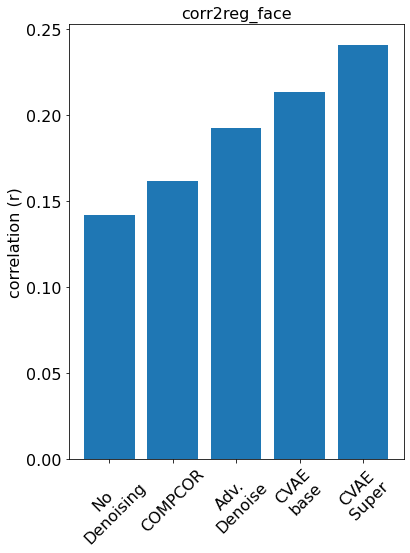

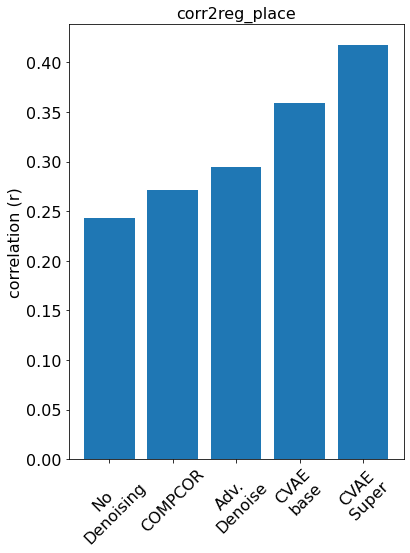

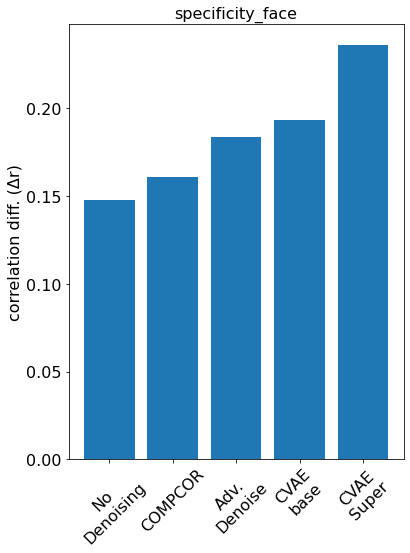

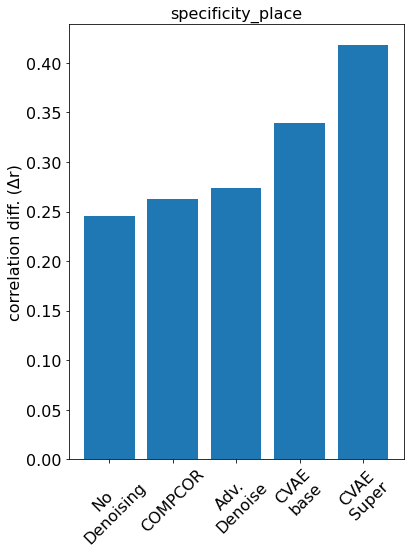

In [97]:
for key in ['corr2reg_face','corr2reg_place','specificity_face','specificity_place']:
    plt.figure(figsize=(6,8))
    ys = df.iloc[row_idx][key].values
    xs = np.arange(len(ys))
    plt.bar(xs,ys)
    plt.xticks(xs,labels=model_names,fontsize=16,rotation=45);
    plt.yticks(fontsize=16)
    plt.title(key,fontsize=16)
    plt.ylabel(units[key],fontsize=16)

In [36]:
print(result_preproc.mean(axis=0).mean(axis=0)/result_preproc.mean(axis=1).std(axis=0))
print(result_compcor.mean(axis=0).mean(axis=0)/result_preproc.mean(axis=1).std(axis=0))
print(result_conv_denoise.mean(axis=0).mean(axis=0)/result_preproc.mean(axis=1).std(axis=0))
print(result_CVAE_Yu.mean(axis=0).mean(axis=0)/result_preproc.mean(axis=1).std(axis=0))
print(result_CVAE_AA.mean(axis=0).mean(axis=0)/result_preproc.mean(axis=1).std(axis=0))

[2.25618443 1.94809626 2.46739291 2.52780261 2.35344197 2.66549919]
[2.57257221 2.15080679 2.68127381 2.78208554 2.57402542 2.81255389]
[3.05785635 2.83423534 3.04217093 2.99803599 2.94318111 3.03286483]
[3.21945079 2.06941646 3.46967329 3.61071156 2.91789677 3.55194617]
[3.75894091 2.71428022 4.05253685 4.22962269 3.68161357 4.39489057]


In [37]:
print(result_preproc.mean(axis=0).mean(axis=0))
print(result_compcor.mean(axis=0).mean(axis=0))
print(result_conv_denoise.mean(axis=0).mean(axis=0))
print(result_CVAE_Yu.mean(axis=0).mean(axis=0))
print(result_CVAE_AA.mean(axis=0).mean(axis=0))

[0.1472324  1.8665312  0.24945448 3.6869406  0.15193063 0.25152648]
[0.16787899 2.06075443 0.27107793 4.05782639 0.16617079 0.26540311]
[0.1995473  2.71556843 0.30756478 4.37280213 0.19000229 0.28619248]
[0.21009251 1.98277184 0.35078545 5.2664235  0.18837001 0.33517494]
[0.24529815 2.60063573 0.40971321 6.16913977 0.23767311 0.41471833]


In [38]:
# result[s,r-1,0] = corr2reg_face
# result[s,r-1,1] = contrastVal_face
# result[s,r-1,2] = corr2reg_place
# result[s,r-1,3] = contrastVal_place
# result[s,r-1,4] = specificity